# Trends in Remote Job Listings on Indeed.com

We'll use Parsehub to scrape Indeed.com for the recently posted job listings. We will specify results that are:

- posted in the last 24 hours
- posted in the 'remote' location

This document doesn't detail setting up the Parsehub web scraper. For now all we need to know is that scraped files go into the 'Data/indeed/' directory as .csvs.

We will look at one of these files and analyze it to get started. 

In [257]:
#import tools
import pandas as pd
import numpy as np

#load csvs into dataframes
oct09 = pd.read_csv('Data/indeed/indeed100820.csv')

#info about our data
oct09.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   job_title_name             215 non-null    object
 1   job_title_url              215 non-null    object
 2   job_title_salary           125 non-null    object
 3   job_title_company_name     215 non-null    object
 4   job_title_job_description  183 non-null    object
 5   job_title_relatedLinks     183 non-null    object
dtypes: object(6)
memory usage: 10.2+ KB


In [258]:
#preview data
oct09.head()

,job_title_name,job_title_url,job_title_salary,job_title_company_name,job_title_job_description,job_title_relatedLinks
0,BILINGUAL ENGLISH/MANDARIN HOTEL RESEARCH SPEC...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"$35,000 - $42,000 a year",Lodging Econometrics,Join a growing team that’s as obsessed with re...,Research Specialist jobs in Remote\nJobs at Lo...
1,Project Manager,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"$75,000 - $100,000 a year",OSMOSE UTILITIES SERVICES INC,"About Osmose\nWith 85 years of experience, Osm...","Project Manager jobs in Atlanta, GA\nJobs at O..."
2,Home Care Marketer - Business Development,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"$50,000 - $85,000 a year",Pleet Home Care CDPAP,Pleet Home Care CDPAP located in the Heart of ...,Business Development Manager jobs in Remote\nJ...
3,Editorial/Administrative Assistant (EST),https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,$15 an hour,Epitec,This is an administrative role supporting scie...,Editorial Assistant jobs in Remote\nJobs at Ep...
4,Sales Recruiter,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,"$40,000 - $60,000 a year",hear.com,"HEY DENVER, HEAR.COM IS HERE!\nYOU READY FOR U...","Recruiter jobs in Denver, CO\nJobs at hear.com..."


## 1. Grouping jobs based on related links

In order to get a feel for trends we need to group listings somehow. Indeed doesn't tell us how each job is tagged for searches, but it somewhat exposes the general group the job listing belongs to in the related links section. 

We want to crawl job_title_relatedLinks for repeated phrases, then use these phrases to create a tag column.
    Then we will use this info to count the number of times each tag occurs so we can infer what type of jobs are being posted the most right now.

In [259]:
#for each row in the relatedLinks column
#extract the words before the word 'jobs'
#put this value in the tags column 
oct09['tags'] = oct09.job_title_relatedLinks.str.extract(r'(.+?)(?=\sjobs)', expand=False)

#print first five tags to verify working
oct09['tags'].head(25)

0                 Research Specialist
1                     Project Manager
2        Business Development Manager
3                 Editorial Assistant
4                           Recruiter
5     Customer Service Representative
6                 Executive Assistant
7                            Designer
8                     Mortgage Closer
9                     Account Manager
10              Marketing Coordinator
11                    Managing Editor
12            Social Media Specialist
13                   Data Entry Clerk
14                    Legal Assistant
15    Marketing Associate Entry Level
16           Administrative Assistant
17                     Office Manager
18                Fundraising Manager
19                          Recruiter
20                   Data Coordinator
21    Customer Service Representative
22           Administrative Assistant
23              Real Estate Assistant
24               Social Media Manager
Name: tags, dtype: object

Our tags column is working. Lets see what the frequency of each job tag / type is:

In [260]:
#get tag frequencies
oct09['tags'].value_counts()

Customer Service Representative    13
Sales Representative                5
Recruiter                           5
Loan Processor                      4
Sales Coordinator                   4
                                   ..
Freelance Designer                  1
Claims Adjuster                     1
Scheduler                           1
Customer Care Specialist            1
Demonstrator                        1
Name: tags, Length: 133, dtype: int64

Our job listings table has 215 entries for this date, which has sorted down to 133 tags. Therefore little fewer than half of the tags are used twice.

Its also a good sign that some tags occur many times. For instance, 'Customer Service Representative' showed up 13 times.

## 2. Clean up and standardize salary data

Right now our salary column isn't in a numerical format that we can easily do calculations on. If we want to find the median salary for each job tag or the highest paid remote jobs, we'll need to convert it to a better format.

Lets look at the types of values we have in the salary column currently. 

In [261]:
#look at variety of values in 'salary' column
oct09['job_title_salary'].head(50)

0      $35,000 - $42,000 a year
1     $75,000 - $100,000 a year
2      $50,000 - $85,000 a year
3                   $15 an hour
4      $40,000 - $60,000 a year
5       $12.00 - $12.50 an hour
6      $75,000 - $85,000 a year
7                           NaN
8                           NaN
9           From $70,000 a year
10        $800 - $1,000 a month
11     $75,000 - $80,000 a year
12      $1,200 - $1,800 a month
13            $17 - $25 an hour
14            $15 - $20 an hour
15     $28,000 - $30,000 a year
16            $15 - $20 an hour
17            $15 - $20 an hour
18            $17 - $20 an hour
19               $45,000 a year
20                          NaN
21            $16 - $18 an hour
22                          NaN
23                          NaN
24                          NaN
25                          NaN
26            $24 - $30 an hour
27            $20 - $22 an hour
28                          NaN
29            $15 - $20 an hour
30                          NaN
31      

It looks like we get both single values and ranges. We also get salaries listed in hourly, daily, weekly, and yearly formats. In some cases we have no salary information provided. 

Let's write a function to convert all of these salaries to the common denomination of yearly salary. We'll also convert ranges to single values by finding the average of the range. 

In [262]:
#HELPER FUNCTION to convert payment to yearly values
#calculations assume 40 hour/5 day a week/52 weeks a year
def pay_per_year(pay_freq):
    switcher = {
        'hour': 2080,
        'day': 260,
        'week': 52,
        'month': 12,
        'year' : 1
    }
    x = switcher.get(pay_freq)
    return x

#MAIN FUNCTION to loop through job_title_salary column,
#find the average of a range of pay
#and convert pay to yearly salary amount
def convert_salary(column, df):
        
    #extract all numbers into a list
    num_strings = column.str.extractall(r'(?P<numbers>\d+,*\.*\d*)')
    nums = num_strings['numbers'].str.replace(',','').astype(float)
    
    # outputs multilevel dataframe like this
    #    match
    #0   0    min_value_1
    #    1    max_value_1
    #1   0    min_value_2
    #    1    max_value_2
    #2   0    min_value_3
    # ...
    
    #to get the mean of each row, we will groupby the first level and and then get the mean of the 2 values
    avg_pay = nums.groupby(level=0).apply(np.mean)
    
    #use same method as above to extract the frequency of pay
    frequency = column.str.extractall(r'(?P<frequency>hour|day|week|month|year)')
    #our result has a 'match' column, we will ignore it and apply our function to the second column
    pay_periods = frequency['frequency'].apply(pay_per_year)
    #get rid of extra index in results
    pay_periods = pay_periods.unstack()

    
    #calc yearly salary from average pay and pay frequency
    salary = avg_pay * pay_periods[0]
    
    #add the salary column to the dataframe
    df['salary'] = salary


#call functions above on our data 
convert_salary(oct09['job_title_salary'], oct09)

#show results
print(oct09[['job_title_salary','salary']].head(20))

             job_title_salary   salary
0    $35,000 - $42,000 a year  38500.0
1   $75,000 - $100,000 a year  87500.0
2    $50,000 - $85,000 a year  67500.0
3                 $15 an hour  31200.0
4    $40,000 - $60,000 a year  50000.0
5     $12.00 - $12.50 an hour  25480.0
6    $75,000 - $85,000 a year  80000.0
7                         NaN      NaN
8                         NaN      NaN
9         From $70,000 a year  70000.0
10      $800 - $1,000 a month  10800.0
11   $75,000 - $80,000 a year  77500.0
12    $1,200 - $1,800 a month  18000.0
13          $17 - $25 an hour  43680.0
14          $15 - $20 an hour  36400.0
15   $28,000 - $30,000 a year  29000.0
16          $15 - $20 an hour  36400.0
17          $15 - $20 an hour  36400.0
18          $17 - $20 an hour  38480.0
19             $45,000 a year  45000.0


Now we have a standard salary we can use to compare wages on the job. 

*Aside: If we wanted to improve our function a bit more, we might look for words like 'from' and 'up to' in our 'job_title_salary' values as well. We could increase or reduce the average salaries by a small amount based on those qualifiers.*

## 3. Calculate median salary for each tag

We've managed to get a single, standardized number representing each job listing's salary. However, we don't yet have an idea of the overall trend in salaries for each job type / 'tag'. To find that, we'll group the job listings by tag again and then find the median salary.

*Why median instead of average, especially when we used average before?*
We only had 2 numbers before, so we couldnt really find a meaningful median. Since we may have more values per tag now, the median calculation will better account for outlier salaries. 

In [263]:
#get a list of unique tags from 'tags' column
#tags_list = oct09['tags'].unique()
#print(tags_list)

#group dataframe by tag and find the median
median_salary = oct09.groupby(by=['tags']).median()

print(median_salary)

                           salary
tags                             
Account Executive         93068.0
Account Manager           70000.0
Actor                         NaN
Administrative Analyst    56160.0
Administrative Assistant  36400.0
...                           ...
Transaction Coordinator   47840.0
Transaction Manager       31200.0
Transcriptionist          31200.0
Underwriter               89810.5
Workforce Manager             NaN

[133 rows x 1 columns]


## Charting Our Data


Let's start to really look at our data and see if we can identify trends. We'll use charts to better visualize our data. Here's what we'll visualize in this section:


- tag frequency bar chart
- median salary bar chart
- corr chart of frequency and salary

Let's import Matplotlib to assist and get started charting!

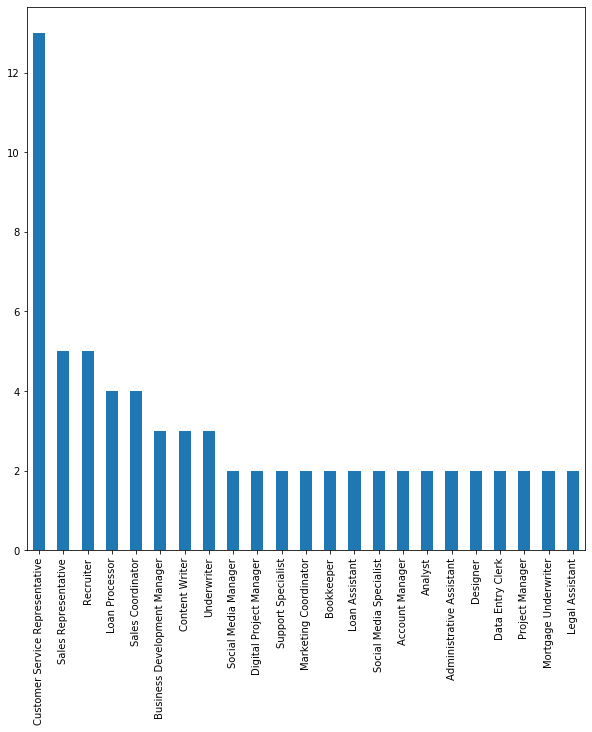

In [264]:
#import graphing library
import matplotlib.pyplot as plt

#load matplotlib inline so we can plot in jupiter notebooks
%matplotlib inline


#get count of each tag
s_freq = oct09['tags'].value_counts()
#remove results with 1 count
s_freq = s_freq[s_freq!=1]
#show frequency bar chart
s_freq.plot.bar('tags', figsize=(10,10))  

                                 tags   salary
Customer Service Representative    13  30940.0
Sales Representative                5  52000.0
Recruiter                           5  50000.0
Loan Processor                      4  53910.0
Sales Coordinator                   4  72500.0
Business Development Manager        3  67500.0
Content Writer                      3  78000.0
Underwriter                         3  89810.5
Social Media Manager                2  43680.0
Digital Project Manager             2      NaN
Support Specialist                  2  28600.0
Marketing Coordinator               2  25400.0
Bookkeeper                          2  48880.0
Loan Assistant                      2  40600.0
Social Media Specialist             2  26500.0
Account Manager                     2  70000.0
Analyst                             2  66500.0
Administrative Assistant            2  36400.0
Designer                            2  48000.0
Data Entry Clerk                    2  43680.0
Project Manag

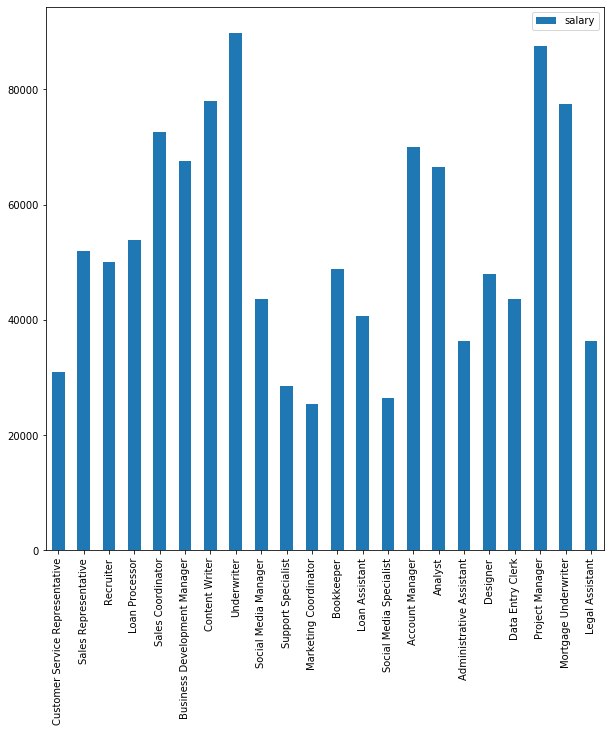

In [265]:
#combine the frequency data with the median salary data
#set to inner join to drop extra median salary data, keep columns same size
combine = pd.concat([s_freq, median_salary], axis=1, join='inner')
print(combine)

#chart the median salaries, minus the null values
combine[combine['salary'].notnull()].plot.bar(y='salary', figsize=(10,10))

## What high-paying jobs are posted relatively often?

Let's see where there's demand for high paying jobs by looking at a scatterplot of lisrtings frequencies and median salaries.

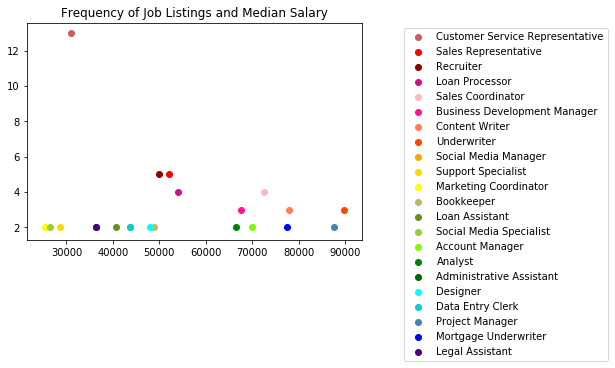

In [266]:
#import color maps
from matplotlib import cm

#remove nulls
combine = combine[combine['salary'].notnull()]

#set x,y coords (for labels)
x_coords = combine['salary']
y_coords = combine['tags']
#if chart has more results than colors in list, add colors to list or errors will occur
colors = ['IndianRed','Red','DarkRed','MediumVioletRed','LightPink','DeepPink','Coral','OrangeRed','Orange','Gold', 'Yellow', 'DarkKhaki', 'OliveDrab', 'YellowGreen','LawnGreen', 'Green', 'DarkGreen','Cyan','DarkTurquoise','SteelBlue','Blue','Indigo']
labels = combine.index
fig = plt.figure()
ax = fig.add_subplot()
plt.title('Frequency of Job Listings and Median Salary')

#for counter i, loop through labels and plot corresponding x,y on a scatter plot
for i, name in enumerate(labels):
    x = x_coords[i]
    y = y_coords[i]
    plt.scatter(x, y, c=colors[i])
    #label dots with a slight horizontal offset
    #plt.text(x+10, y-1, name, fontsize=5)
    
leg = plt.legend(labels)

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
# Change to location of the legend. 
xOffset = .75
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

#cmap = plt.get_cmap('Accent')   
#plt.set_cmap('tab20c')

plt.show()

For now it looks like **Underwriters, Project Managers, Content Writers, and Mortgage Underwriters** are topping out our highly paid list.

**Recruiters, Sales Representatives,and Loan Processors** have a good amount of jobs listings and median salaries reliably over 50k. **Sales Coordinators** also enjoy the same amount of listings and an even higher median salary.

Our above graph isn't colorblind friendly but will do for the purposes of this project. For a more accessible chart, we could draw the plot using differently shaped markers. Details here: https://matplotlib.org/3.2.1/api/markers_api.html

## Analyzing larger trends by looking at multiple spreadsheets

So far we have been analyzing one day of data in one .csv file.

Since we have been scraping data every day for several days, we can concatenate days together to get a better idea of the trends over time. 

In [267]:
#import modules and set path
import glob
path = r'Data/indeed' 

#get all the .csv files in the indeed directory
all_files = glob.glob(path + "/*.csv")

li = []
#for each .csv file
for filename in all_files:
    #read it into a pandas dataframe
    df = pd.read_csv(filename, index_col=None, header=0)
    #append it to the 'li' dataframe list
    li.append(df)

#combine all the dataframes in the list
frame = pd.concat(li, axis=0, ignore_index=True)
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990 entries, 0 to 1989
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   job_title_name             1990 non-null   object
 1   job_title_url              1990 non-null   object
 2   job_title_salary           1029 non-null   object
 3   job_title_company_name     1990 non-null   object
 4   job_title_job_description  1106 non-null   object
 5   job_title_relatedLinks     1106 non-null   object
dtypes: object(6)
memory usage: 93.4+ KB


**Additional columns were added to .csv files starting with indeed101420. The first .csv files captured in october use a different format and might cause an error unless makrup above is re-written to account for it.**

This data came from a daily scrape performed at 2:15 pm each day. Although we tried not to run our scan without the same 24 hour window to avoid duplicates, it's possible timing was imperfect. It would be good to check for duplicate job listings to ensure the data quality. 

## Preventing duplicate job listings
If Indeed.com showed job listing IDs it might be worth scraping those to make our duplicate check foolproof. However, they don't show that info. Luckily we have the next best thing: a url for the job listing. We can use this to check for duplicates. 

*Aside : While we're looking at our data scraper, we've slightly edited it to grab 2 more columns of information: 
- *the location of the company headquarters and 
- *a check for confirmation that the listing was tagged as 'remote'

*The reason we've captured the second value is check for listings that turned up in our remote search even though they were not noted as remote on the site. The descriptions of these listings are generally ambiguous and could be remote or not. Capturing this value allows us to sort out these ambiguous listings in the future if we'd like to. 

In [271]:
#drop duplicate rows using job URL and reset the index
all_data = frame.drop_duplicates(subset=['job_title_url'], keep='first').reset_index()
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1869 entries, 0 to 1868
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   index                      1869 non-null   int64 
 1   job_title_name             1869 non-null   object
 2   job_title_url              1869 non-null   object
 3   job_title_salary           967 non-null    object
 4   job_title_company_name     1869 non-null   object
 5   job_title_job_description  1094 non-null   object
 6   job_title_relatedLinks     1094 non-null   object
dtypes: int64(1), object(6)
memory usage: 102.3+ KB


We went from 1990 entries to 1869 entries, eliminating 21 duplicates in this case. 

## Charting our cleaned, culmulative data

Let's rechart the same info as above. We will have more values in each chart so we may need to change how we view the information.

First we need to generate our tags and median salary data info for this larger dataset.

Text(0.5, 1.0, '# of listings per job')

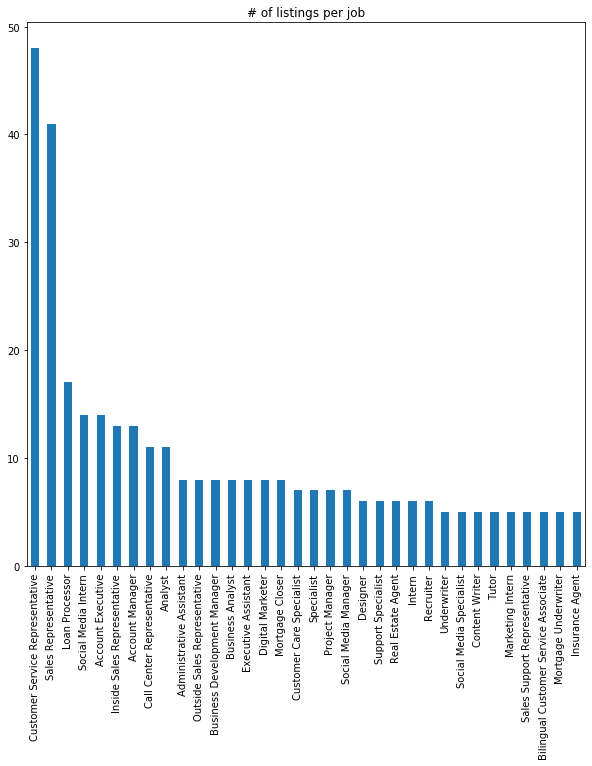

In [278]:
#generate tags column
all_data['tags'] = all_data.job_title_relatedLinks.str.extract(r'(.+?)(?=\sjobs)', expand=False)

#generate salary info
convert_salary(all_data['job_title_salary'], all_data)

#generate median_salary dataframe
median_salary = all_data.groupby(by=['tags']).median()
#show results
#print(all_data[['job_title_salary','salary']].head(20))

#re-chart info above
#get count of each tag
s_freq = all_data['tags'].value_counts()
#remove results with less than 5 counts to get a smaller dataset
s_freq = s_freq[s_freq > 4]
#show frequency bar chart
s_freq.plot.bar('tags', figsize=(10,10))  
plt.title('# of listings per job')

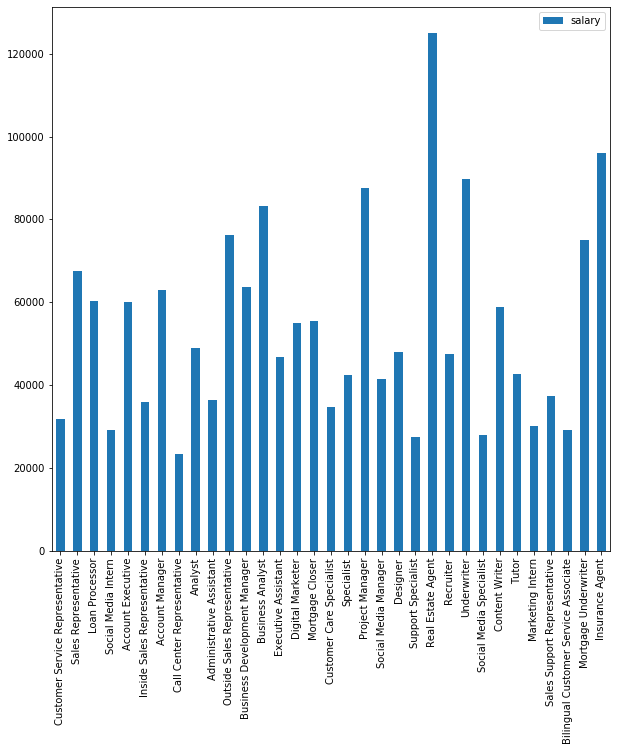

In [280]:
#combine the frequency data with the median salary data
#set to inner join to drop extra median salary data, keep columns same size
combine = pd.concat([s_freq, median_salary], axis=1, join='inner')

#chart the median salaries, minus the null values
combine[combine['salary'].notnull()].plot.bar(y='salary', figsize=(10,10))

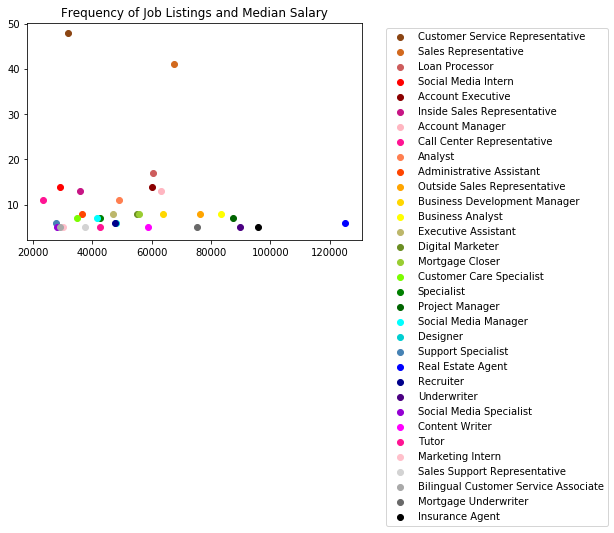

In [285]:
#remove nulls
combine = combine[combine['salary'].notnull()]

#set x,y coords (for labels)
x_coords = combine['salary']
y_coords = combine['tags']
#if chart has more results than colors in list, add colors to list or errors will occur
colors = ['SaddleBrown','Chocolate','IndianRed','Red','DarkRed','MediumVioletRed','LightPink','DeepPink','Coral','OrangeRed','Orange','Gold', 'Yellow', 'DarkKhaki', 'OliveDrab', 'YellowGreen','LawnGreen', 'Green', 'DarkGreen','Cyan','DarkTurquoise','SteelBlue','Blue','DarkBlue','Indigo','DarkViolet','Magenta','DeepPink','Pink','LightGray','DarkGray','DimGray','Black','IndianRed','Red','DarkRed','MediumVioletRed','LightPink','DeepPink','Coral','OrangeRed','Orange','Gold', 'Yellow', 'DarkKhaki', 'OliveDrab', 'YellowGreen','LawnGreen', 'Green', 'DarkGreen','Cyan','DarkTurquoise','SteelBlue','Blue','DarkBlue','Indigo','DarkViolet','Magenta','DeepPink']
labels = combine.index
fig = plt.figure()
ax = fig.add_subplot()
plt.title('Frequency of Job Listings and Median Salary')

#for counter i, loop through labels and plot corresponding x,y on a scatter plot
for i, name in enumerate(labels):
    x = x_coords[i]
    y = y_coords[i]
    plt.scatter(x, y, c=colors[i])
    #label dots with a slight horizontal offset
    #plt.text(x+10, y-1, name, fontsize=5)
    
leg = plt.legend(labels)

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
# Change to location of the legend. 
xOffset = .75
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

plt.show()

## Conclusions

It looks like the patterns we observed before are holding true. A few more job titles have joined the chart. Keep in mind, this is only about a weeks worth of data so far. 

We are definetly getting into 'hard to read' territory with this chart. If we keep this going across several months of data, we might need to further split out this information and show the best and worst jobs on seperate charts. 